In [ ]:
!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

Archive:  /content/VisDrone2019-DET-val.zip
replace /content/dataset/VisDrone2019-DET-val/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
import os
import shutil
from PIL import Image as PILImage
import numpy as np
import cv2
import random
import time
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

In [ ]:
IMG_DIR = '/content/dataset/VisDrone2019-DET-val/images'
ANN_DIR = '/content/dataset/VisDrone2019-DET-val/annotations'
NEW_IMG_DIR = '/content/newimages'
NEW_ANN_DIR = '/content/newannotations'
FRAME_FILE = '/content/frames.txt'

os.makedirs(NEW_IMG_DIR, exist_ok=True)
os.makedirs(NEW_ANN_DIR, exist_ok=True)

In [35]:
def prepare_dataset_subsets(
    base_image_path: Path,
    base_annotation_path: Path,
    target_image_path: Path,
    target_annotation_path: Path,
    crop_instructions_file: Path,
    vehicle_class_id: str = '4'
):
    target_image_path.mkdir(parents=True, exist_ok=True)
    target_annotation_path.mkdir(parents=True, exist_ok=True)

    if not crop_instructions_file.is_file():
        print(f"Error: Crop instructions file not found at {crop_instructions_file}")
        return

    with open(crop_instructions_file, 'r') as f_in:
        for line_num, instruction_line in enumerate(f_in):
            elements = [elem.strip() for elem in instruction_line.strip().split(',')]
            if len(elements) < 5:
                print(f"Skipping malformed line {line_num+1} in {crop_instructions_file}: {instruction_line.strip()}")
                continue

            img_filename = elements[0]
            try:
                crop_x, crop_y = int(elements[1]), int(elements[2])
                crop_w, crop_h = int(elements[3]), int(elements[4])
            except ValueError:
                print(f"Invalid coordinate/dimension in line {line_num+1} of {crop_instructions_file}: {instruction_line.strip()}")
                continue

            if crop_w <= 0 or crop_h <= 0 or crop_x < 0 or crop_y < 0:
                print(f"Invalid crop dimensions for {img_filename}: X={crop_x}, Y={crop_y}, W={crop_w}, H={crop_h}")
                continue

            source_img_file = base_image_path / img_filename
            source_annot_file = base_annotation_path / (Path(img_filename).stem + '.txt')

            dest_img_file = target_image_path / img_filename
            dest_annot_file = target_annotation_path / (Path(img_filename).stem + '.txt')

            if not source_img_file.is_file():
                print(f"Source image not found: {source_img_file}")
                continue

            try:
                with PILImage.open(source_img_file) as image_obj:
                    cropped_image_obj = image_obj.crop((crop_x, crop_y, crop_x + crop_w, crop_y + crop_h))
                    cropped_image_obj.save(dest_img_file)
            except Exception as e:
                print(f"Error processing image {source_img_file}: {e}")
                continue

            modified_annotations = []
            if source_annot_file.is_file():
                with open(source_annot_file, 'r') as ann_f_in:
                    for annot_line in ann_f_in:
                        annot_parts = [part.strip() for part in annot_line.strip().split(',')]
                        if len(annot_parts) >= 6:
                            try:
                                obj_x, obj_y = int(annot_parts[0]), int(annot_parts[1])
                                obj_w, obj_h = int(annot_parts[2]), int(annot_parts[3])
                                obj_ignored_status = annot_parts[4]
                                obj_class = annot_parts[5]
                                remaining_data = annot_parts[6:]
                            except ValueError:
                                print(f"Malformed annotation line in {source_annot_file}: {annot_line.strip()}")
                                continue

                            if obj_class == vehicle_class_id:
                                if obj_x >= crop_x and obj_y >= crop_y and \
                                   (obj_x + obj_w) <= (crop_x + crop_w) and \
                                   (obj_y + obj_h) <= (crop_y + crop_h):

                                    adj_obj_x = obj_x - crop_x
                                    adj_obj_y = obj_y - crop_y

                                    new_annot_entry = [str(adj_obj_x), str(adj_obj_y), str(obj_w), str(obj_h), obj_ignored_status, obj_class] + remaining_data
                                    modified_annotations.append(','.join(new_annot_entry) + '\n')

            if modified_annotations:
                with open(dest_annot_file, 'w') as ann_f_out:
                    ann_f_out.writelines(modified_annotations)
    print("Dataset preprocessing complete.")

In [48]:
class SyntheticImageDataset(Dataset):
    def __init__(self, num_samples: int, image_source_dir: str, annotation_source_dir: str):
        self.num_samples = num_samples
        self.img_dir = Path(image_source_dir)
        self.annot_dir = Path(annotation_source_dir)

        self.available_images = [f.name for f in self.img_dir.glob("*.jpg")]
        if not self.available_images:
            raise ValueError(f"No images found in {self.img_dir}")

        self.available_annotations = {f.stem: f.name for f in self.annot_dir.glob("*.txt")}

    def __len__(self) -> int:
        return self.num_samples

    def _fetch_cv2_image(self, image_name: str) -> np.ndarray | None:
        image_data = cv2.imread(str(self.img_dir / image_name))
        return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB) if image_data is not None else None

    def _get_object_bboxes(self, annotation_name: str) -> list[tuple[int, int, int, int]]:
        bboxes = []
        annot_filepath = self.annot_dir / annotation_name
        if annot_filepath.is_file():
            with open(annot_filepath, 'r') as f:
                for line in f:
                    attrs = list(map(int, line.strip().split(',')[:6]))
                    if attrs[5] == 4:
                        x, y, w, h = attrs[0], attrs[1], attrs[2], attrs[3]
                        bboxes.append((x, y, x + w, y + h))
        return bboxes

    def _get_color_profile(self, image_array: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        avg, s_dev = cv2.meanStdDev(image_array)
        return avg.flatten(), s_dev.flatten()

    def _match_color_profile(self, target_img: np.ndarray, reference_img: np.ndarray) -> np.ndarray:
        target_avg, target_s_dev = self._get_color_profile(target_img)
        ref_avg, ref_s_dev = self._get_color_profile(reference_img)

        target_s_dev[target_s_dev < 1e-5] = 1e-5

        corrected_img = ((target_img - target_avg) * (ref_s_dev / target_s_dev)) + ref_avg
        return np.clip(corrected_img, 0, 255).astype(np.uint8)

    def _prepare_image_elements(self, base_img: np.ndarray, obj_patches_data: list[tuple[np.ndarray, tuple[int,int,int,int]]]) -> tuple[np.ndarray, list[tuple[np.ndarray, tuple[int, int]]]]:
        random_ref_img_name = random.choice(self.available_images)
        reference_image = self._fetch_cv2_image(random_ref_img_name)
        if reference_image is None:
            reference_image = base_img

        color_corrected_base = self._match_color_profile(base_img, reference_image)

        processed_patches = []
        for patch, (x_start, y_start, x_end, y_end) in obj_patches_data:
            corrected_patch = self._match_color_profile(patch, reference_image)
            patch_dims = (x_end - x_start, y_end - y_start)
            processed_patches.append((corrected_patch, patch_dims))

        return color_corrected_base, processed_patches

    def _calculate_iou(self, boxA: tuple[int,int,int,int], boxB: tuple[int,int,int,int]) -> float:
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        intersection = max(0, xB - xA) * max(0, yB - yA)
        if intersection == 0:
            return 0.0

        areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

        union = float(areaA + areaB - intersection)
        return intersection / union if union > 0 else 0.0

    def _embed_objects_on_canvas(self, canvas_img: np.ndarray, patch_list: list[tuple[np.ndarray, tuple[int,int]]], max_attempts_per_patch: int = 15, overlap_threshold: float = 0.4) -> tuple[np.ndarray, list[tuple[int,int,int,int]]]:
        canvas_h, canvas_w = canvas_img.shape[:2]
        finalized_bboxes = []

        for individual_patch, (patch_orig_w, patch_orig_h) in patch_list:
            current_scale = random.uniform(0.6, 1.1)
            scaled_w = int(patch_orig_w * current_scale)
            scaled_h = int(patch_orig_h * current_scale)

            if scaled_w < 5 or scaled_h < 5: continue

            resized_patch = cv2.resize(individual_patch, (scaled_w, scaled_h), interpolation=cv2.INTER_LANCZOS4) # Different interpolation

            is_placed = False
            for _ in range(max_attempts_per_patch):
                pos_x = random.randint(0, max(0, canvas_w - scaled_w))
                pos_y = random.randint(0, max(0, canvas_h - scaled_h))

                candidate_bbox = (pos_x, pos_y, pos_x + scaled_w, pos_y + scaled_h)

                has_major_overlap = False
                for existing_bbox in finalized_bboxes:
                    iou = self._calculate_iou(candidate_bbox, existing_bbox)
                    if iou > overlap_threshold:
                        has_major_overlap = True
                        break

                if not has_major_overlap:
                    patch_mask = 255 * np.ones(resized_patch.shape, resized_patch.dtype)
                    center_coords = (pos_x + scaled_w // 2, pos_y + scaled_h // 2)
                    try:
                        canvas_img = cv2.seamlessClone(resized_patch, canvas_img, patch_mask, center_coords, cv2.NORMAL_CLONE)
                        finalized_bboxes.append(candidate_bbox)
                        is_placed = True
                        break
                    except cv2.error as e:
                        print(f"Warning: seamlessClone failed: {e}")
        return canvas_img, finalized_bboxes

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, list[tuple[int,int,int,int]], int]:
        obj_patch_img_name, bg_img_name = random.sample(self.available_images, 2)

        obj_patch_annot_name = self.available_annotations.get(Path(obj_patch_img_name).stem)

        source_objects_bboxes = []
        if obj_patch_annot_name:
            source_objects_bboxes = self._get_object_bboxes(obj_patch_annot_name)

        while not source_objects_bboxes:
            obj_patch_img_name = random.choice(self.available_images)
            obj_patch_annot_name = self.available_annotations.get(Path(obj_patch_img_name).stem)
            if obj_patch_annot_name:
                 source_objects_bboxes = self._get_object_bboxes(obj_patch_annot_name)
            if obj_patch_img_name == bg_img_name:
                bg_img_name = random.choice(list(set(self.available_images) - {obj_patch_img_name}))
                if not bg_img_name: bg_img_name = obj_patch_img_name


        source_patch_image = self._fetch_cv2_image(obj_patch_img_name)
        background_image_canvas = self._fetch_cv2_image(bg_img_name)

        if source_patch_image is None or background_image_canvas is None:
            print("Error loading images for dataset item, returning dummy.")
            dummy_img = torch.zeros((3, 100, 100), dtype=torch.float32)
            dummy_bbox = torch.zeros((1, 4), dtype=torch.int32)
            return dummy_img, dummy_bbox, dummy_img, [], 0

        bg_annot_name = self.available_annotations.get(Path(bg_img_name).stem)
        bg_existing_bboxes = []
        if bg_annot_name:
            bg_existing_bboxes = self._get_object_bboxes(bg_annot_name)

        object_cutouts = []
        for x_start, y_start, x_end, y_end in source_objects_bboxes:
            cutout = source_patch_image[y_start:y_end, x_start:x_end]
            if cutout.size > 0:
                 object_cutouts.append((cutout, (x_start, y_start, x_end, y_end)))

        if not object_cutouts:
            dummy_img = torch.from_numpy(source_patch_image.transpose(2,0,1)).float()
            dummy_bbox = torch.tensor(source_objects_bboxes if source_objects_bboxes else [[0,0,0,0]], dtype=torch.int32)
            return dummy_img, dummy_bbox, torch.from_numpy(background_image_canvas.transpose(2,0,1)).float(), bg_existing_bboxes, 0

        processed_canvas, processed_patches = self._prepare_image_elements(background_image_canvas, object_cutouts)
        synthesized_image, new_object_bboxes = self._embed_objects_on_canvas(processed_canvas.copy(), processed_patches) # Use copy of canvas

        all_final_bboxes = bg_existing_bboxes + new_object_bboxes

        tensor_source_patch_img = torch.from_numpy(source_patch_image.transpose(2,0,1)).float() / 255.0
        tensor_source_bboxes = torch.tensor(source_objects_bboxes, dtype=torch.int32)
        tensor_final_synth_img = torch.from_numpy(synthesized_image.transpose(2,0,1)).float() / 255.0

        return tensor_source_patch_img, tensor_source_bboxes, tensor_final_synth_img, all_final_bboxes, len(new_object_bboxes)

In [37]:
def detect_circular_objects(image_rgb: np.ndarray, hough_dp: float = 1.2, hough_min_dist: int = 80,
                            hough_p1: int = 120, hough_p2: int = 35,
                            rad_min: int = 8, rad_max: int = 60,
                            canny_thresh_val: int = 90) -> list[tuple[int,int,int,int]]:
    img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    img_blurred = cv2.GaussianBlur(img_gray, (7, 7), 1.5)

    edges_detected = cv2.Canny(img_blurred, canny_thresh_val // 2, canny_thresh_val)

    morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    morph_processed = cv2.morphologyEx(edges_detected, cv2.MORPH_OPEN, morph_kernel)

    detected_circles = cv2.HoughCircles(morph_processed, cv2.HOUGH_GRADIENT, dp=hough_dp, minDist=hough_min_dist,
                                        param1=hough_p1, param2=hough_p2,
                                        minRadius=rad_min, maxRadius=rad_max)
    output_bboxes = []
    if detected_circles is not None:
        valid_circles = np.uint16(np.around(detected_circles))
        for (cx, cy, r_val) in valid_circles[0, :]:
            x1, y1 = max(0, cx - r_val), max(0, cy - r_val)
            x2, y2 = cx + r_val, cy + r_val
            output_bboxes.append((x1, y1, x2, y2))
    return output_bboxes

In [43]:
def detect_elliptical_objects(image_rgb: np.ndarray, contour_min_points: int = 6,
                              area_thresh_min: int = 800, area_thresh_max: int = 18000,
                              canny_edge_thresh: int = 60, aspect_limit: float = 3.5) -> list[tuple[int,int,int,int]]:
    img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    img_blurred = cv2.medianBlur(img_gray, 5)
    edge_map = cv2.Canny(img_blurred, canny_edge_thresh, canny_edge_thresh * 2.5)
    op_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_edges = cv2.morphologyEx(edge_map, cv2.MORPH_CLOSE, op_kernel, iterations=2)
    image_contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    fitted_bboxes = []
    for contour_pts in image_contours:
        if len(contour_pts) < contour_min_points:
            continue

        obj_area = cv2.contourArea(contour_pts)
        if not (area_thresh_min < obj_area < area_thresh_max):
            continue

        if len(contour_pts) > contour_min_points:
            try:
                bounding_rect = cv2.minAreaRect(contour_pts)
            except cv2.error:
                continue

            rect_dims = bounding_rect[1]
            rect_w, rect_h = rect_dims[0], rect_dims[1]

            if min(rect_w, rect_h) <= 0: continue

            current_aspect_ratio = max(rect_w, rect_h) / min(rect_w, rect_h)
            if current_aspect_ratio > aspect_limit:
                continue

            box_corners = cv2.boxPoints(bounding_rect)
            box_corners_int = box_corners.astype(int)
            x_coord, y_coord, w_val, h_val = cv2.boundingRect(box_corners_int)
            fitted_bboxes.append((x_coord, y_coord, x_coord + w_val, y_coord + h_val))

    return fitted_bboxes

In [39]:
def non_max_suppression_boxes(boxes_list: list[tuple[int,int,int,int]], iou_thresh: float) -> list[tuple[int,int,int,int]]:
    if not boxes_list:
        return []

    pick = []
    x1 = np.array([b[0] for b in boxes_list])
    y1 = np.array([b[1] for b in boxes_list])
    x2 = np.array([b[2] for b in boxes_list])
    y2 = np.array([b[3] for b in boxes_list])

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = np.argsort(y2)

    while order.size > 0:
        last = order.size - 1
        i = order[last]
        pick.append(boxes_list[i])

        xx1 = np.maximum(x1[i], x1[order[:last]])
        yy1 = np.maximum(y1[i], y1[order[:last]])
        xx2 = np.minimum(x2[i], x2[order[:last]])
        yy2 = np.minimum(y2[i], y2[order[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[order[:last]]

        order = np.delete(order, np.concatenate(([last], np.where(overlap > iou_thresh)[0])))

    return pick

In [38]:
def find_objects_by_template(main_image_rgb: np.ndarray, template_rgb: np.ndarray,
                             detection_threshold: float = 0.6,
                             scale_range: tuple[float,float,float] = (0.4, 1.3, 0.15), # start, stop, step
                             angle_range: tuple[int,int,int] = (-90, 91, 15) # start, stop, step
                            ) -> list[tuple[int,int,int,int]]:
    main_gray = cv2.cvtColor(main_image_rgb, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template_rgb, cv2.COLOR_RGB2GRAY)

    if template_gray.shape[0] < 5 or template_gray.shape[1] < 5:
        return []

    (tmpl_h_orig, tmpl_w_orig) = template_gray.shape[:2]
    found_boxes = []

    scale_steps = np.arange(scale_range[0], scale_range[1], scale_range[2])
    angle_steps = np.arange(angle_range[0], angle_range[1], angle_range[2])

    for current_scale, current_angle in itertools.product(scale_steps, angle_steps):
        w_scaled = int(tmpl_w_orig * current_scale)
        h_scaled = int(tmpl_h_orig * current_scale)

        if w_scaled < 10 or h_scaled < 10 or w_scaled > main_gray.shape[1] or h_scaled > main_gray.shape[0]:
            continue

        resized_template = cv2.resize(template_gray, (w_scaled, h_scaled), interpolation=cv2.INTER_AREA) # Different interpolation

        rotation_center = (w_scaled // 2, h_scaled // 2)
        rot_matrix = cv2.getRotationMatrix2D(rotation_center, current_angle, 1.0)
        rotated_template = cv2.warpAffine(resized_template, rot_matrix, (w_scaled, h_scaled),
                                          flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

        if rotated_template.shape[0] < 10 or rotated_template.shape[1] < 10:
            continue

        match_results = cv2.matchTemplate(main_gray, rotated_template, cv2.TM_CCORR_NORMED)

        locs = np.where(match_results >= detection_threshold)
        for (pt_y, pt_x) in zip(*locs):
            top_left_x, top_left_y = pt_x, pt_y
            bottom_right_x, bottom_right_y = top_left_x + w_scaled, top_left_y + h_scaled
            found_boxes.append((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

    refined_boxes = non_max_suppression_boxes(found_boxes, iou_thresh=0.1)
    return refined_boxes

In [46]:
def calculate_count_based_precision(predictions_counts: list[int], groundtruth_counts: list[int]) -> float:
    if len(predictions_counts) != len(groundtruth_counts) or not predictions_counts:
        return 0.0

    individual_precisions = []
    for pred_n, gt_n in zip(predictions_counts, groundtruth_counts):
        true_pos = min(pred_n, gt_n)
        false_pos = max(0, pred_n - gt_n)

        if (true_pos + false_pos) > 0:
            precision_val = true_pos / (true_pos + false_pos)
        else:
            precision_val = 1.0 if pred_n == 0 and gt_n == 0 else 0.0
        individual_precisions.append(precision_val)

    return np.mean(individual_precisions) if individual_precisions else 0.0

def create_mask_from_bboxes(box_coordinates: list, mask_dims: tuple[int, int]) -> np.ndarray:
    output_mask = np.zeros(mask_dims, dtype=np.uint8)
    for item in box_coordinates:
        actual_box_coords = None
        if isinstance(item, tuple) and len(item) == 4:
            if all(isinstance(coord, (int, float, np.number)) for coord in item):
                actual_box_coords = item
        elif isinstance(item, tuple) and len(item) == 1 and \
             isinstance(item[0], tuple) and len(item[0]) == 4:
            if all(isinstance(coord, (int, float, np.number)) for coord in item[0]):
                actual_box_coords = item[0]

        if actual_box_coords:
            x_min, y_min, x_max, y_max = map(int, actual_box_coords)

            cv2.rectangle(output_mask,
                          (max(0, x_min), max(0, y_min)),
                          (min(mask_dims[1] - 1, x_max), min(mask_dims[0] - 1, y_max)),
                          color=1, thickness=-1)

    return output_mask

def evaluate_segmentation_accuracy(predicted_binary_mask: np.ndarray, true_binary_mask: np.ndarray) -> float:
    if predicted_binary_mask.shape != true_binary_mask.shape:
        raise ValueError("Mask dimensions must match for accuracy calculation.")

    pred_bool = predicted_binary_mask.astype(bool)
    true_bool = true_binary_mask.astype(bool)

    intersection = np.logical_and(pred_bool, true_bool).sum() # TP
    pred_sum = pred_bool.sum()
    true_sum = true_bool.sum()

    union = np.logical_or(pred_bool, true_bool).sum() # TP + FP + FN

    iou_score = intersection / union if union > 0 else 0.0
    return iou_score

def refine_detected_boxes(box_list: list[tuple[int,int,int,int]],
                          min_obj_area: int = 900, max_obj_area: int = 16000,
                          aspect_limits: tuple[float,float] = (0.4, 2.5)) -> list[tuple[int,int,int,int]]:
    validated_boxes = []
    for (x_s, y_s, x_e, y_e) in box_list:
        box_w, box_h = x_e - x_s, y_e - y_s
        if box_w <=0 or box_h <=0: continue

        current_area = box_w * box_h
        if not (min_obj_area <= current_area <= max_obj_area):
            continue

        ratio = box_w / box_h
        if not (aspect_limits[0] <= ratio <= aspect_limits[1]):
            continue
        validated_boxes.append((x_s, y_s, x_e, y_e))
    return validated_boxes

Dataset preprocessing complete.
Image 1 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 1 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


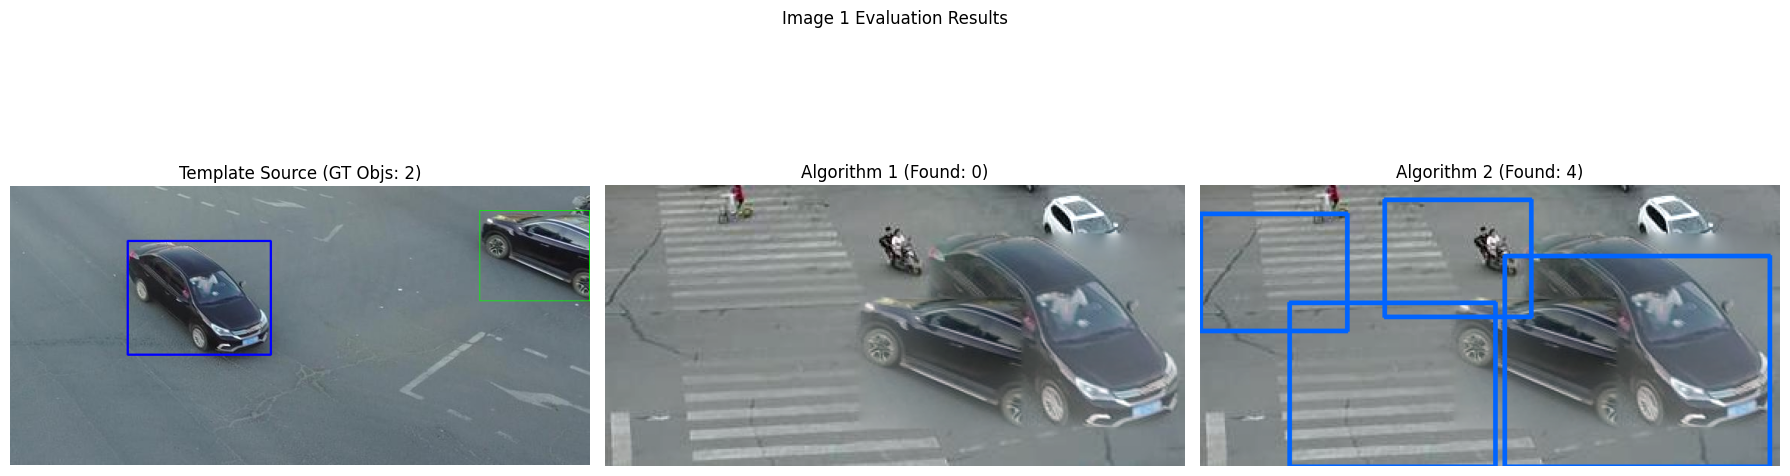

Image 2 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 2 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


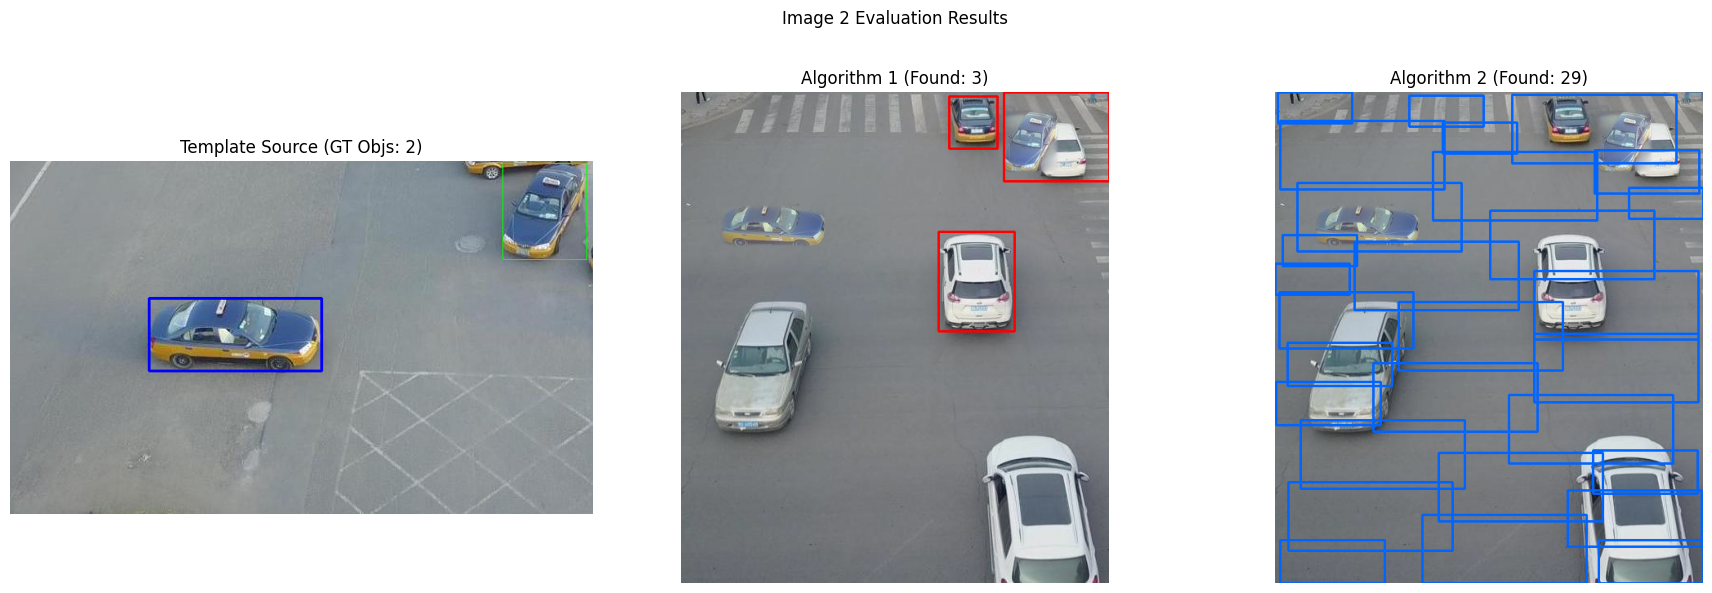

Image 3 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 3 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


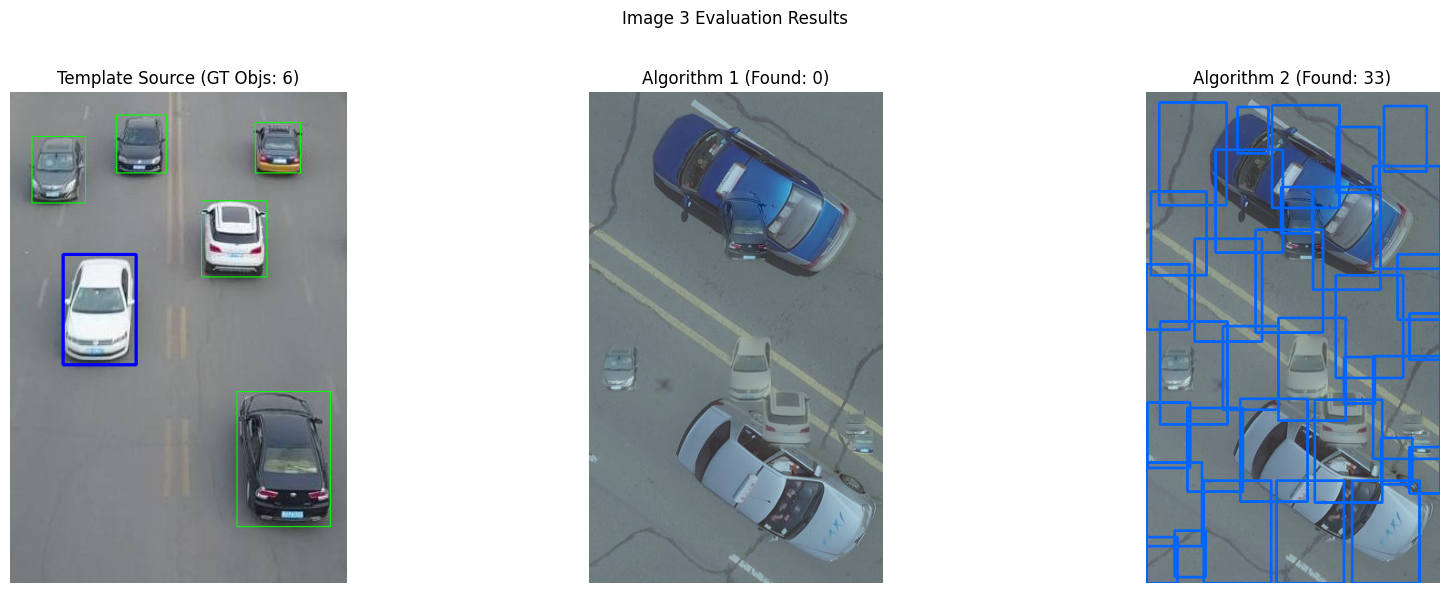

Image 4 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 4 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


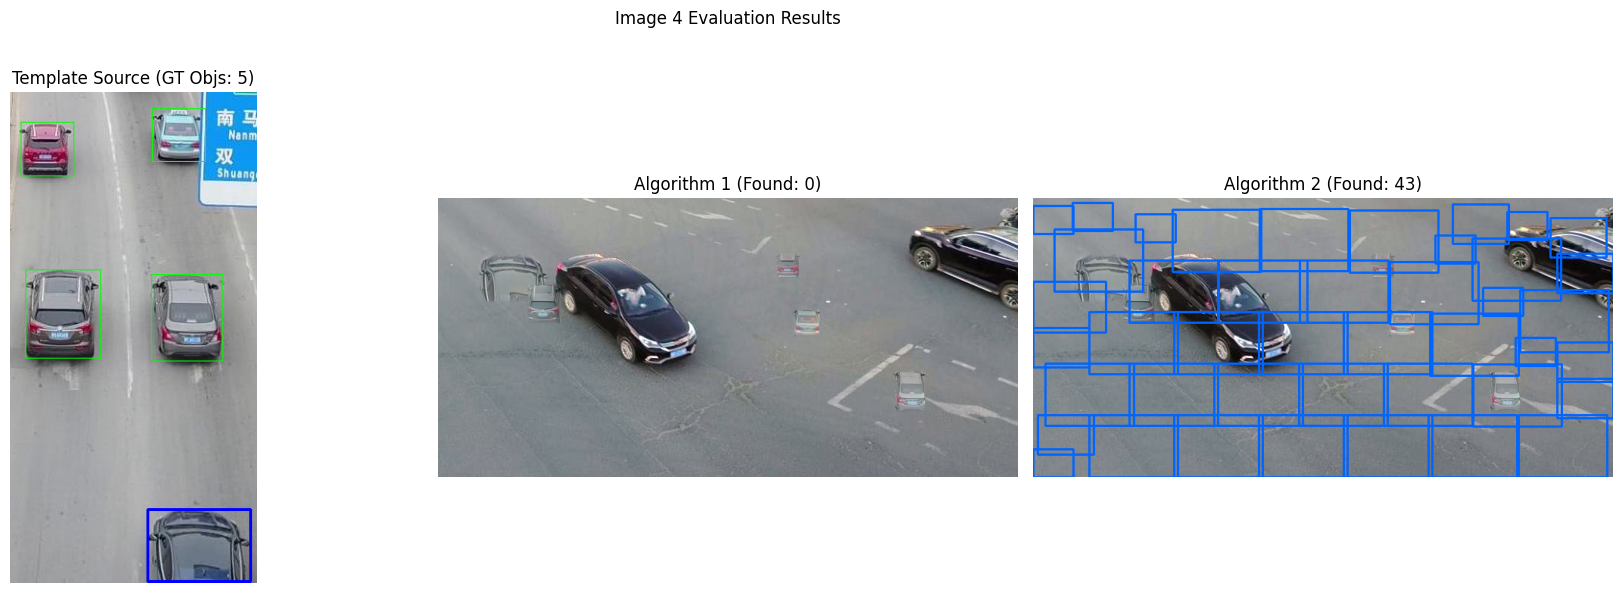

Image 5 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 5 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


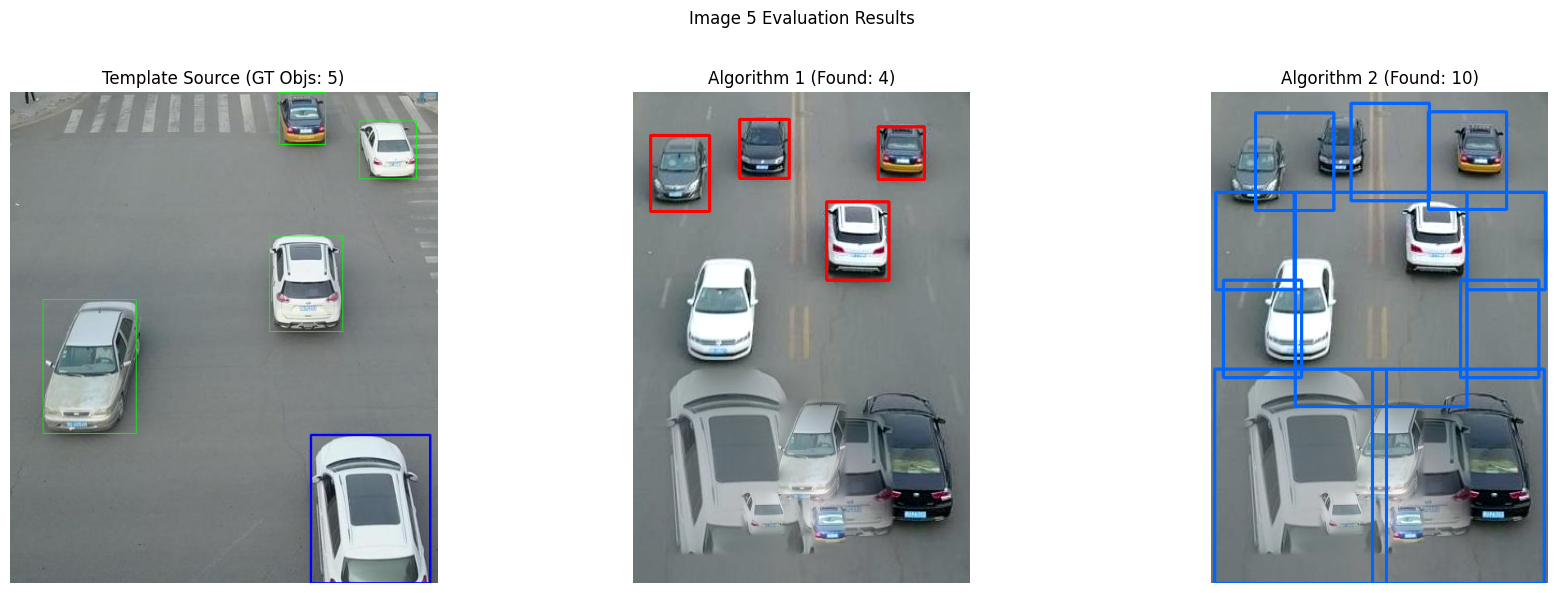

Image 6 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 6 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


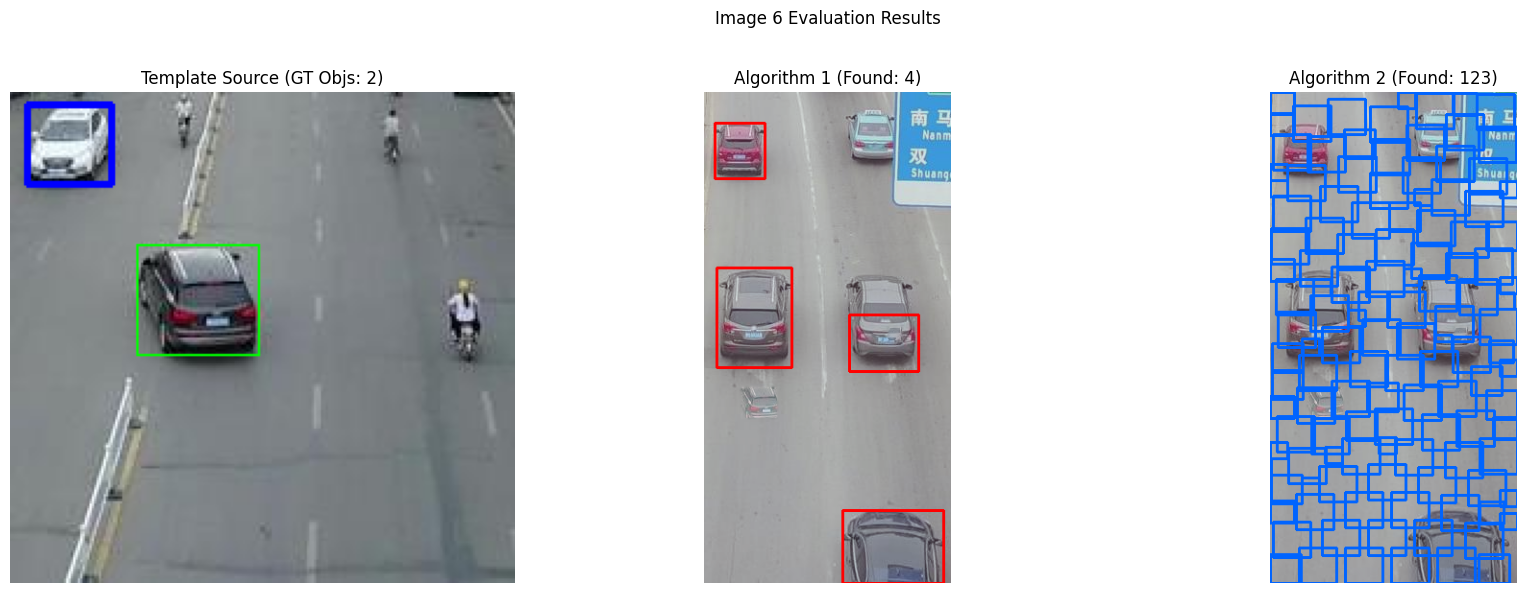

Image 7 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 7 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


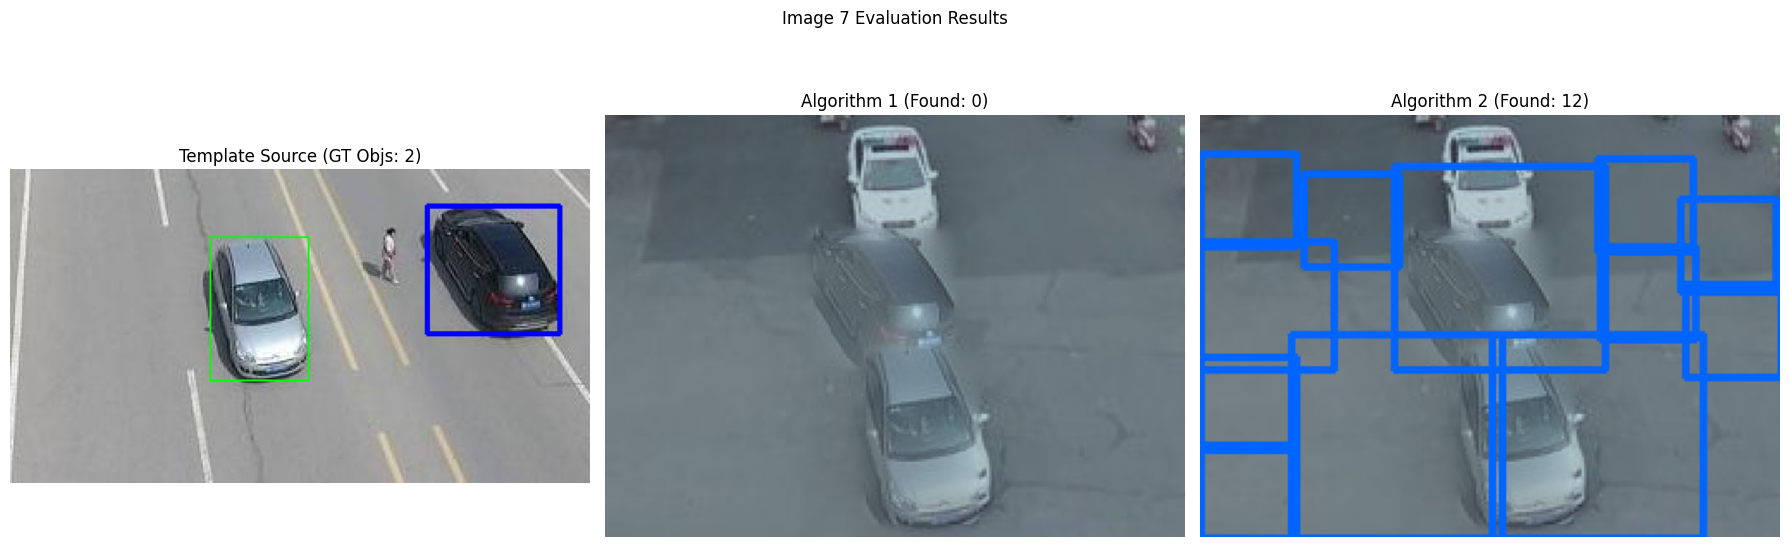

Image 8 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 8 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


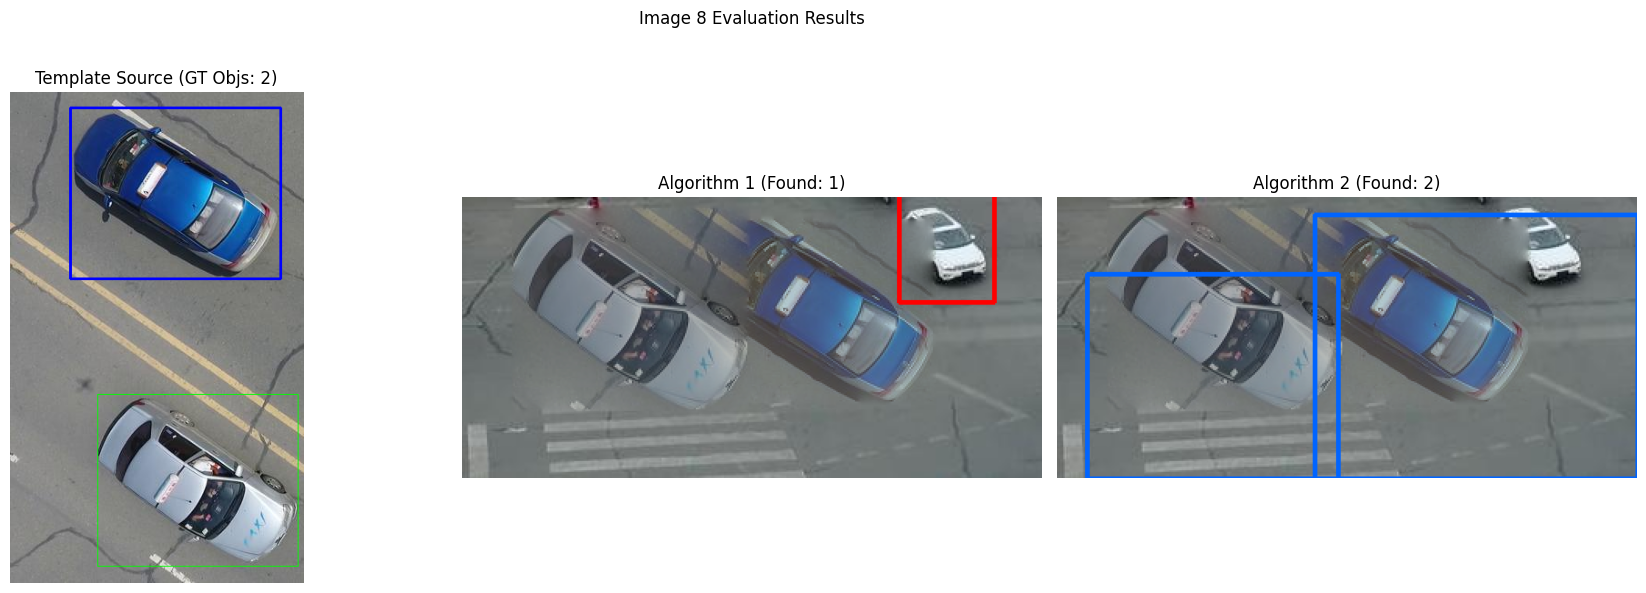

Image 9 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 9 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


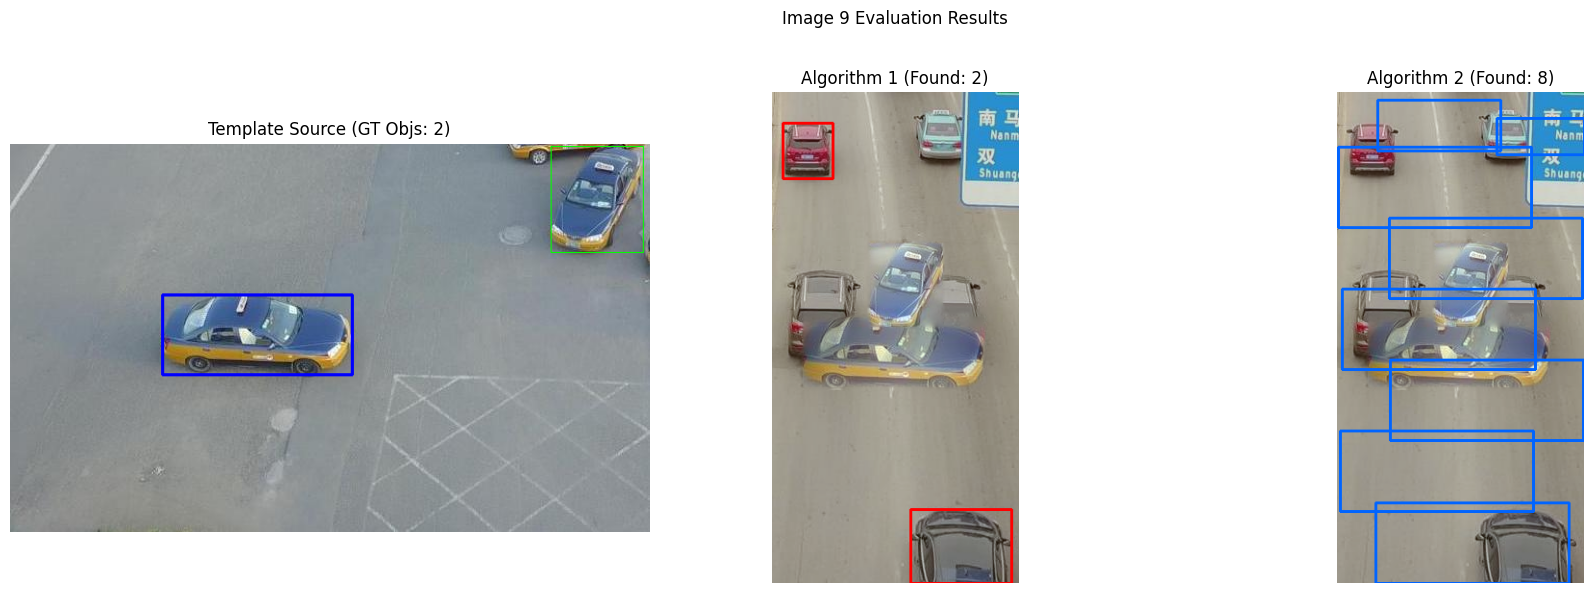

Image 10 - Algo 1 (Circles/Ellipses) - Pixel IoU: 0.0000
Image 10 - Algo 2 (Template Matching) - Pixel IoU: 0.0000


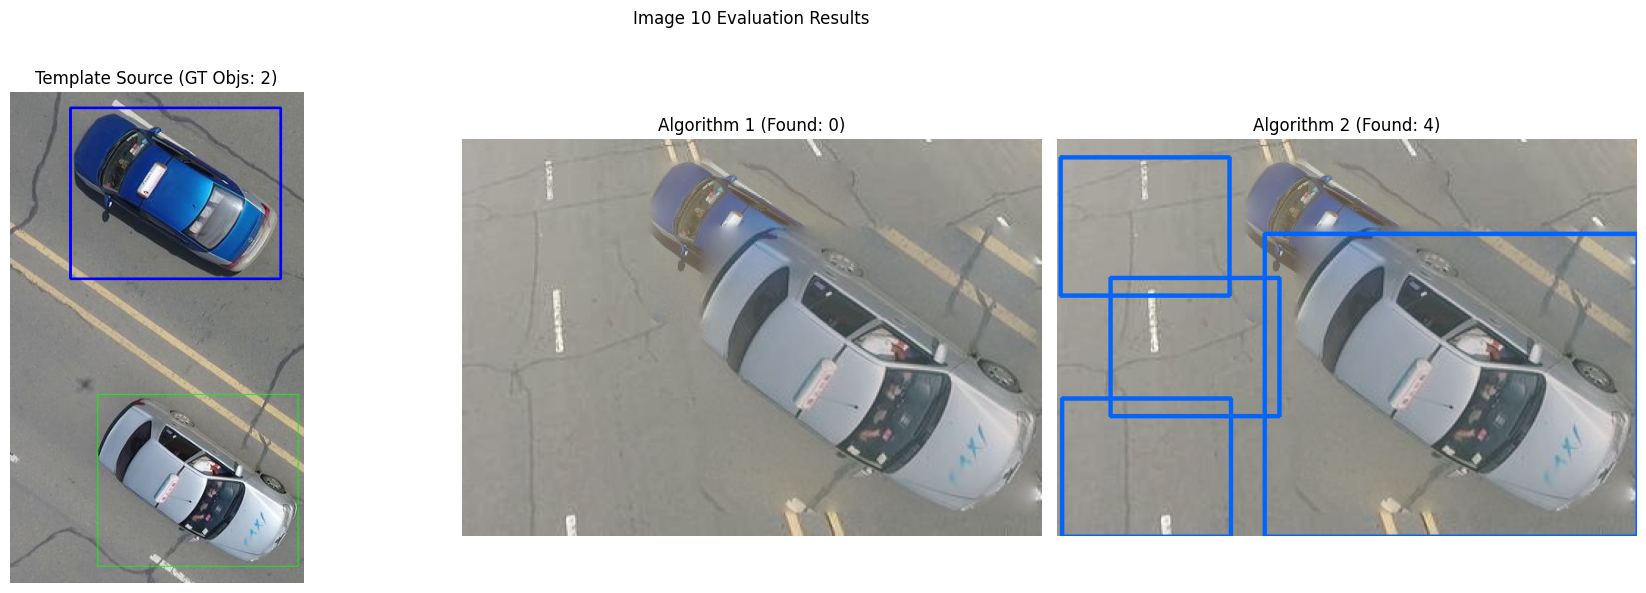


--- Final Evaluation Summary ---
Algorithm 1 (Combined Circle/Ellipse Detection):
  Average Object Count Precision: 0.417
  Average Pixel-level IoU (Jaccard): 0.0000
  Average Processing Time: 0.0144 seconds

Algorithm 2 (Template Matching):
  Average Object Count Precision: 0.330
  Average Pixel-level IoU (Jaccard): 0.0000
  Average Processing Time: 3.4332 seconds


In [49]:
visdrone_base_imgs_dir = Path('/content/dataset/VisDrone2019-DET-val/images')
visdrone_base_annots_dir = Path('/content/dataset/VisDrone2019-DET-val/annotations')
image_crop_definitions_file = Path('/content/frames.txt')

processed_imgs_storage = Path('/content/derived_images_processed')
processed_annots_storage = Path('/content/derived_annotations_processed')

if processed_imgs_storage.exists(): shutil.rmtree(processed_imgs_storage)
if processed_annots_storage.exists(): shutil.rmtree(processed_annots_storage)

prepare_dataset_subsets(
    visdrone_base_imgs_dir,
    visdrone_base_annots_dir,
    processed_imgs_storage,
    processed_annots_storage,
    image_crop_definitions_file
)

num_test_images = 10

if not processed_imgs_storage.exists() or not any(processed_imgs_storage.iterdir()):
      print(f"Error: No processed images found in {processed_imgs_storage}. Cannot proceed with dataset initialization.")
      if not processed_imgs_storage.exists(): processed_imgs_storage.mkdir(parents=True, exist_ok=True)
      if not processed_annots_storage.exists(): processed_annots_storage.mkdir(parents=True, exist_ok=True)
      if not any(processed_imgs_storage.iterdir()):
        print("Creating a dummy image/annotation for dataset initialization.")
        dummy_pil_img = PILImage.new('RGB', (100,100), color='red')
        dummy_pil_img.save(processed_imgs_storage / "dummy_img.jpg")
        with open(processed_annots_storage / "dummy_img.txt", "w") as f:
            f.write("10,10,20,20,0,4,0,0\n")


main_dataset = SyntheticImageDataset(
    num_samples=num_test_images,
    image_source_dir=str(processed_imgs_storage),
    annotation_source_dir=str(processed_annots_storage)
)

if not main_dataset.available_images:
    print("Critical Error: Dataset could not be initialized with any valid images. Exiting.")
    exit()

image_loader = DataLoader(main_dataset, batch_size=1, shuffle=False)


actual_obj_counts_list = []

algo1_detected_counts = []
algo1_exec_times = []
algo1_pixel_iou_scores = []

algo2_detected_counts = []
algo2_exec_times = []
algo2_pixel_iou_scores = []

for idx, data_batch in enumerate(image_loader):
    template_source_tensor, template_bboxes_tensor, final_image_tensor, gt_bboxes_list, actual_obj_count = data_batch

    template_src_img_np = (template_source_tensor[0].numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    target_eval_img_np = (final_image_tensor[0].numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    current_gt_count = actual_obj_count.item()
    actual_obj_counts_list.append(current_gt_count)

    available_template_bboxes = template_bboxes_tensor[0].numpy()
    object_template_patch = None
    if len(available_template_bboxes) > 0:
        t_x1, t_y1, t_x2, t_y2 = available_template_bboxes[0]
        t_x1, t_y1 = max(0, t_x1), max(0, t_y1)
        t_x2 = min(template_src_img_np.shape[1], t_x2)
        t_y2 = min(template_src_img_np.shape[0], t_y2)
        if t_x2 > t_x1 and t_y2 > t_y1:
              object_template_patch = template_src_img_np[t_y1:t_y2, t_x1:t_x2]

    if object_template_patch is None or object_template_patch.size == 0:
        print(f"Warning: Could not extract a valid template for image {idx+1}. Using a dummy patch.")
        object_template_patch = np.zeros((20, 20, 3), dtype=np.uint8)
        object_template_patch[:,:,0] = 255

    start_ts_algo1 = time.perf_counter()

    circle_detections = detect_circular_objects(target_eval_img_np.copy(), hough_dp=1.3, hough_min_dist=90, rad_min=12, rad_max=55)
    ellipse_detections = detect_elliptical_objects(target_eval_img_np.copy(), area_thresh_min=700, area_thresh_max=17000)

    raw_combined_detections = circle_detections + ellipse_detections
    nms_combined_results = non_max_suppression_boxes(raw_combined_detections, iou_thresh=0.35)
    filtered_algo1_results = refine_detected_boxes(nms_combined_results, min_obj_area=800, aspect_limits=(0.5, 2.2))

    end_ts_algo1 = time.perf_counter()
    algo1_exec_times.append(end_ts_algo1 - start_ts_algo1)
    algo1_detected_counts.append(len(filtered_algo1_results))

    img_h, img_w = target_eval_img_np.shape[:2]
    current_gt_bboxes_for_mask = gt_bboxes_list[0] if isinstance(gt_bboxes_list, list) and gt_bboxes_list and isinstance(gt_bboxes_list[0], list) else gt_bboxes_list

    true_obj_mask = create_mask_from_bboxes(current_gt_bboxes_for_mask, (img_h, img_w))
    algo1_pred_mask = create_mask_from_bboxes(filtered_algo1_results, (img_h, img_w))
    algo1_iou = evaluate_segmentation_accuracy(algo1_pred_mask, true_obj_mask)
    algo1_pixel_iou_scores.append(algo1_iou)
    print(f"Image {idx+1} - Algo 1 (Circles/Ellipses) - Pixel IoU: {algo1_iou:.4f}")

    start_ts_algo2 = time.perf_counter()
    template_match_detections = find_objects_by_template(target_eval_img_np.copy(), object_template_patch, detection_threshold=0.65, scale_range=(0.5,1.1,0.2), angle_range=(-60,61,30))
    filtered_algo2_results = template_match_detections
    end_ts_algo2 = time.perf_counter()

    algo2_exec_times.append(end_ts_algo2 - start_ts_algo2)
    algo2_detected_counts.append(len(filtered_algo2_results))

    algo2_pred_mask = create_mask_from_bboxes(filtered_algo2_results, (img_h, img_w))
    algo2_iou = evaluate_segmentation_accuracy(algo2_pred_mask, true_obj_mask)
    algo2_pixel_iou_scores.append(algo2_iou)
    print(f"Image {idx+1} - Algo 2 (Template Matching) - Pixel IoU: {algo2_iou:.4f}")

    display_template_src = cv2.cvtColor(template_src_img_np, cv2.COLOR_RGB2BGR)
    display_algo1_result = cv2.cvtColor(target_eval_img_np, cv2.COLOR_RGB2BGR)
    display_algo2_result = cv2.cvtColor(target_eval_img_np, cv2.COLOR_RGB2BGR)

    for x1,y1,x2,y2 in available_template_bboxes:
          cv2.rectangle(display_template_src, (x1,y1), (x2,y2), (0,255,0), 1)
    if object_template_patch is not None:
        t_x1, t_y1, t_x2, t_y2 = available_template_bboxes[0]
        cv2.rectangle(display_template_src, (t_x1,t_y1), (t_x2,t_y2), (255,0,0), 2)

    for x1,y1,x2,y2 in filtered_algo1_results:
        cv2.rectangle(display_algo1_result, (x1,y1), (x2,y2), (0,0,255), 2)

    for x1,y1,x2,y2 in filtered_algo2_results:
        cv2.rectangle(display_algo2_result, (x1,y1), (x2,y2), (255,100,0), 2)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(cv2.cvtColor(display_template_src, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Template Source (GT Objs: {current_gt_count})')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(display_algo1_result, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Algorithm 1 (Found: {len(filtered_algo1_results)})')
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(display_algo2_result, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Algorithm 2 (Found: {len(filtered_algo2_results)})')
    axes[2].axis('off')

    plt.suptitle(f'Image {idx+1} Evaluation Results')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

avg_precision_algo1 = calculate_count_based_precision(algo1_detected_counts, actual_obj_counts_list)
avg_precision_algo2 = calculate_count_based_precision(algo2_detected_counts, actual_obj_counts_list)

mean_time_algo1 = np.mean(algo1_exec_times) if algo1_exec_times else 0
mean_iou_algo1 = np.mean(algo1_pixel_iou_scores) if algo1_pixel_iou_scores else 0

mean_time_algo2 = np.mean(algo2_exec_times) if algo2_exec_times else 0
mean_iou_algo2 = np.mean(algo2_pixel_iou_scores) if algo2_pixel_iou_scores else 0

print("\n--- Final Evaluation Summary ---")
print("Algorithm 1 (Combined Circle/Ellipse Detection):")
print(f"  Average Object Count Precision: {avg_precision_algo1:.3f}")
print(f"  Average Pixel-level IoU (Jaccard): {mean_iou_algo1:.4f}")
print(f"  Average Processing Time: {mean_time_algo1:.4f} seconds")

print("\nAlgorithm 2 (Template Matching):")
print(f"  Average Object Count Precision: {avg_precision_algo2:.3f}")
print(f"  Average Pixel-level IoU (Jaccard): {mean_iou_algo2:.4f}")
print(f"  Average Processing Time: {mean_time_algo2:.4f} seconds")